In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset,TensorDataset
from autoencoder import Autoencoder
import torchvision
from model2 import classification_model
import copy
import partition
from pca import PCADigitReducer
from autoencoder import reduce_dimensions
from training import train,test, train_fashion,test_fashion
from federated_learning import distribute_global_model, federated_averaging
from model4 import MultilayerPerceptron
import cluster

# Data Preprocessing

In [2]:
# Predefined stuff

n_epochs = 5
batch_size_train = 100
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [3]:
# training and testing data as dataloaders

train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

In [4]:
train_loader_pca = copy.copy(train_loader)
test_loader_pca = copy.copy(test_loader)

train_loader_auto = copy.copy(train_loader)
test_loader_auto = copy.copy(test_loader)

In [5]:
class CustomTensorDataset(TensorDataset):
    def __init__(self, *tensors):
        super().__init__(*tensors)
        self.data = tensors[0]
        self.targets = tensors[1] 

# PCA

In [6]:
train_data = []
train_labels = []
for data, labels in train_loader_pca:
    train_data.append(data.view(data.size(0), -1))  
    train_labels.append(labels)
train_data = torch.cat(train_data, dim=0)  
train_labels = torch.cat(train_labels, dim=0)

train_data_np = train_data.numpy()

pca = PCADigitReducer(100)
train_data_reduced = pca.fit_transform(train_data_np)  

train_data_reconstructed_np = pca.inverse_transform(train_data_reduced) 
train_data_reconstructed = torch.tensor(train_data_reconstructed_np, dtype=torch.float32)

train_data_reconstructed = train_data_reconstructed.view(-1, 1, 28, 28)

train_data_reconstructed = (train_data_reconstructed - 0.1307) / 0.3081

batch_size_train = train_loader_pca.batch_size
train_dataset_pca = CustomTensorDataset(train_data_reconstructed, train_labels)
train_loader_reduced_pca = DataLoader(train_dataset_pca, batch_size=batch_size_train, shuffle=True)

# Autoencoder

In [7]:
latent_dim = 100  
autoencoder = Autoencoder(latent_dim=latent_dim)
auto_criterion = nn.MSELoss()
auto_optimizer = optim.Adam(autoencoder.parameters(), lr=1e-3)
auto_num_epochs = 5
for epoch in range(auto_num_epochs): 
    for images, _ in train_loader_auto:
        auto_optimizer.zero_grad()
        reconstructed = autoencoder(images)
        loss = auto_criterion(reconstructed, images)  
        loss.backward()
        auto_optimizer.step()
        
    print(f"Epoch [{epoch+1}/5], Loss: {loss.item()}")

Epoch [1/5], Loss: 0.5662664175033569
Epoch [2/5], Loss: 0.5423806309700012
Epoch [3/5], Loss: 0.5064288377761841
Epoch [4/5], Loss: 0.5391950607299805
Epoch [5/5], Loss: 0.5142180323600769


In [8]:
autoencoder.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
latent_features, labels = reduce_dimensions(train_loader_auto, autoencoder.encoder, device)
latent_features = latent_features.detach()

reconstructed_images = autoencoder.decoder(latent_features.to(device))  
reconstructed_images = reconstructed_images.view(-1, 1, 28, 28)  # Reshape to [batch_size, channels, height, width]

reconstructed_dataset = CustomTensorDataset(reconstructed_images.cpu(), labels)  
reduced_train_loader_auto = DataLoader(reconstructed_dataset, batch_size=batch_size_train, shuffle=True)

# Experiment

In [15]:
alpha = 0.5
num_clients = 10
num_clusters = [2, 4, 6, 8, 10]
results = {"classic": {}, "pca": {}, "autoencoder": {}}
clusteredResults = {"classic": {}, "pca": {}, "autoencoder": {}}

# Classic

In [16]:
# classic
trainingset = train_loader.dataset
trial_model = classification_model()
global_model_classic = classification_model()
rounds_classic = 4

In [17]:

# Classic
partitioned_data_classic = partition.balanced_dirichlet_partition(
    trainingset, partitions_number=num_clients, alpha=alpha
)

classic_client_loaders = [
    DataLoader(Subset(trainingset, indices), batch_size=batch_size_train, shuffle=True)
    for indices in partitioned_data_classic.values()
]


local_models_classic = [copy.deepcopy(global_model_classic) for _ in range(num_clients)]

optimizer = optim.SGD(trial_model.parameters(), lr=learning_rate, momentum=momentum)

train_losses = []
train_counter = []

for epoch in range(1, n_epochs + 1):
    train(epoch, trial_model, train_loader, optimizer, log_interval, train_losses, train_counter)

test_losses_classic_weak = []
test(trial_model, test_loader, test_losses_classic_weak)

for round_idx in range(rounds_classic):
    print(f"Round {round_idx + 1}/{rounds_classic}")

    local_weights_classic = []
    for client_idx, client_model in enumerate(local_models_classic):
        print(f"Training client {client_idx + 1}")

        optimizer = optim.SGD(client_model.parameters(), lr=learning_rate, momentum=momentum)

        train_losses = []
        train_counter = []

        for epoch in range(1, n_epochs + 1):
            train(epoch, client_model, classic_client_loaders[client_idx], optimizer, log_interval, train_losses, train_counter)

        client_weights = [param.data.numpy() for param in client_model.parameters()]
        local_weights_classic.append(client_weights)

    global_weights_classic = federated_averaging(local_weights_classic)

    distribute_global_model(global_weights_classic, local_models_classic, single=False)
    distribute_global_model(global_weights_classic, global_model_classic, single=True)

    test_losses = []
    test(global_model_classic, test_loader, test_losses)

    test_accuracies_classic = []
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = global_model_classic(data)
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum().item()
    accuracy = 100. * correct / len(test_loader.dataset)
    test_accuracies_classic.append(accuracy)

    
    results["classic"]["NoCluster"] = {"losses": [], "accuracy": []}

    results["classic"]["NoCluster"]["losses"].extend(test_losses)
    results["classic"]["NoCluster"]["accuracy"].extend(test_accuracies_classic)

    ######################

for num_cluster in num_clusters:
    import cluster

    cluster = cluster.Cluster(num_clusters=num_cluster)

    targets = trainingset.targets
    num_classes = len(set(targets))
    clustered_data = cluster.apply_clustering(partitioned_data_classic, targets, num_classes)

    partitioned_data_classic_clustered = clustered_data

    classic_client_loaders_clustered = [
        DataLoader(Subset(trainingset, indices), batch_size=batch_size_train, shuffle=True)
        for indices in partitioned_data_classic_clustered.values()
    ]

    for round_idx in range(rounds_classic):
        print(f"Round {round_idx + 1}/{rounds_classic}")

        local_weights_classic = []
        for client_idx, client_model in enumerate(local_models_classic[0: num_cluster]):
            print(f"Training client {client_idx + 1}")

            optimizer = optim.SGD(client_model.parameters(), lr=learning_rate, momentum=momentum)

            train_losses = []
            train_counter = []

            for epoch in range(1, n_epochs + 1):
                train(epoch, client_model, classic_client_loaders_clustered[client_idx], optimizer, log_interval, train_losses, train_counter)

            client_weights = [param.data.numpy() for param in client_model.parameters()]
            local_weights_classic.append(client_weights)

        global_weights_classic = federated_averaging(local_weights_classic)

        distribute_global_model(global_weights_classic, local_models_classic, single=False)
        distribute_global_model(global_weights_classic, global_model_classic, single=True)

        test_losses = []
        test(global_model_classic, test_loader, test_losses)

        test_accuracies_classic = []
        correct = 0
        with torch.no_grad():
            for data, target in test_loader:
                output = global_model_classic(data)
                pred = output.data.max(1, keepdim=True)[1]
                correct += pred.eq(target.data.view_as(pred)).sum().item()
        accuracy = 100. * correct / len(test_loader.dataset)
        test_accuracies_classic.append(accuracy)

        # Save results for clustered classic
        if num_cluster not in clusteredResults["classic"]:
            clusteredResults["classic"][num_cluster] = {"losses": [], "accuracy": []}

        clusteredResults["classic"][num_cluster]["losses"].extend(test_losses)
        clusteredResults["classic"][num_cluster]["accuracy"].extend(test_accuracies_classic)

C:\Users\nazek\Documents\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.373595
Train Epoch: 1 [1000/60000 (2%)]	Loss: 2.305434
Train Epoch: 1 [2000/60000 (3%)]	Loss: 2.275401
Train Epoch: 1 [3000/60000 (5%)]	Loss: 2.236221
Train Epoch: 1 [4000/60000 (7%)]	Loss: 2.229350
Train Epoch: 1 [5000/60000 (8%)]	Loss: 2.255284
Train Epoch: 1 [6000/60000 (10%)]	Loss: 2.156510
Train Epoch: 1 [7000/60000 (12%)]	Loss: 2.163547
Train Epoch: 1 [8000/60000 (13%)]	Loss: 2.094289
Train Epoch: 1 [9000/60000 (15%)]	Loss: 1.931286
Train Epoch: 1 [10000/60000 (17%)]	Loss: 1.849544
Train Epoch: 1 [11000/60000 (18%)]	Loss: 1.680981
Train Epoch: 1 [12000/60000 (20%)]	Loss: 1.765529
Train Epoch: 1 [13000/60000 (22%)]	Loss: 1.637998
Train Epoch: 1 [14000/60000 (23%)]	Loss: 1.575528
Train Epoch: 1 [15000/60000 (25%)]	Loss: 1.372618
Train Epoch: 1 [16000/60000 (27%)]	Loss: 1.366193
Train Epoch: 1 [17000/60000 (28%)]	Loss: 1.338472
Train Epoch: 1 [18000/60000 (30%)]	Loss: 1.362826
Train Epoch: 1 [19000/60000 (32%)]	Loss: 1.224796
Train Epoch: 1 [200

C:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0953, Accuracy: 9712/10000 (97%)

Round 1/4
Training client 1
Train Epoch: 1 [0/8115 (0%)]	Loss: 2.316167
Train Epoch: 1 [1000/8115 (12%)]	Loss: 2.285567
Train Epoch: 1 [2000/8115 (24%)]	Loss: 2.112308
Train Epoch: 1 [3000/8115 (37%)]	Loss: 2.090798
Train Epoch: 1 [4000/8115 (49%)]	Loss: 2.072531
Train Epoch: 1 [5000/8115 (61%)]	Loss: 1.891539
Train Epoch: 1 [6000/8115 (73%)]	Loss: 1.953943
Train Epoch: 1 [7000/8115 (85%)]	Loss: 1.545866
Train Epoch: 1 [8000/8115 (98%)]	Loss: 1.527554
Train Epoch: 2 [0/8115 (0%)]	Loss: 1.598513
Train Epoch: 2 [1000/8115 (12%)]	Loss: 1.456909
Train Epoch: 2 [2000/8115 (24%)]	Loss: 1.555620
Train Epoch: 2 [3000/8115 (37%)]	Loss: 1.302094
Train Epoch: 2 [4000/8115 (49%)]	Loss: 1.193891
Train Epoch: 2 [5000/8115 (61%)]	Loss: 1.334609
Train Epoch: 2 [6000/8115 (73%)]	Loss: 1.216613
Train Epoch: 2 [7000/8115 (85%)]	Loss: 1.056974
Train Epoch: 2 [8000/8115 (98%)]	Loss: 0.896495
Train Epoch: 3 [0/8115 (0%)]	Loss: 1.147276
Train Epoch: 3

In [18]:
print("Final Results (Non-Clustered):", results)
print("Final Results (Clustered):", clusteredResults)

Final Results (Non-Clustered): {'classic': {'NoCluster': {'losses': [0.18525345458984374], 'accuracy': [94.79]}}, 'pca': {}, 'autoencoder': {}}
Final Results (Clustered): {'classic': {2: {'losses': [0.09909869842529297, 0.07459216079711914, 0.06054996032714844, 0.05474312973022461], 'accuracy': [96.88, 97.73, 98.09, 98.33]}, 4: {'losses': [0.05091021118164062, 0.04768744163513183, 0.04525685920715332, 0.04398232955932617], 'accuracy': [98.42, 98.44, 98.53, 98.56]}, 6: {'losses': [0.04332631206512451, 0.04393983325958252, 0.0421296781539917, 0.04153912963867187], 'accuracy': [98.56, 98.65, 98.65, 98.65]}, 8: {'losses': [0.04043581085205078, 0.04011364212036133, 0.03945069770812988, 0.03908075199127197], 'accuracy': [98.65, 98.69, 98.7, 98.72]}, 10: {'losses': [0.039182378768920896, 0.03894012145996094, 0.03881264247894287, 0.03854283676147461], 'accuracy': [98.72, 98.66, 98.71, 98.75]}}, 'pca': {}, 'autoencoder': {}}


# PCA

In [19]:
# PCA
trainingset_pca = train_loader_reduced_pca.dataset
trial_model_pca = classification_model()
global_model_pca = classification_model() 

In [20]:

partitioned_data_pca = partition.balanced_dirichlet_partition(trainingset_pca, partitions_number=num_clients, alpha=0.5)

pca_client_loaders = [
    DataLoader(Subset(trainingset_pca, indices), batch_size=batch_size_train, shuffle=True)
    for indices in partitioned_data_pca.values()
]



local_models_pca = [copy.deepcopy(global_model_pca) for _ in range(num_clients)]

optimizer = optim.SGD(trial_model_pca.parameters(), lr=learning_rate, momentum=momentum)

train_losses = []
train_counter = []

for epoch in range(1, n_epochs + 1):  
    train(epoch, trial_model_pca, train_loader_reduced_pca, optimizer, log_interval, train_losses, train_counter)

test_losses_classic_pca = []
test(trial_model_pca, train_loader_reduced_pca, test_losses_classic_pca)

rounds_pca = 4

for round_idx in range(rounds_pca):
    print(f"Round {round_idx + 1}/{rounds_pca}")

    local_weights_pca = []
    for client_idx, client_model in enumerate(local_models_pca):
        print(f"Training client {client_idx + 1}")
        
        optimizer = optim.SGD(client_model.parameters(), lr=learning_rate, momentum=momentum)

        train_losses = []
        train_counter = []

        for epoch in range(1, n_epochs + 1):  
            train(epoch, client_model, pca_client_loaders[client_idx], optimizer, log_interval, train_losses, train_counter)
        
        client_weights = [param.data.numpy() for param in client_model.parameters()]
        local_weights_pca.append(client_weights)
        
    global_weights_pca = federated_averaging(local_weights_pca)

    distribute_global_model(global_weights_pca, local_models_pca, single=False)
    distribute_global_model(global_weights_pca, global_model_pca, single=True)

    test_losses = []
    test(global_model_pca, test_loader_pca, test_losses)
    
    test_accuracies_pca = []
    correct = 0
    with torch.no_grad():
        for data, target in test_loader_pca:
            output = global_model_pca(data)
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum().item()
    accuracy = 100. * correct / len(test_loader_pca.dataset)
    test_accuracies_pca.append(accuracy)

    results["pca"]["NoCluster"] = {"losses": [], "accuracy": []}

    results["pca"]["NoCluster"]["losses"].extend(test_losses)
    results["pca"]["NoCluster"]["accuracy"].extend(test_accuracies_pca)

    ######################

for num_cluster in num_clusters:
    import cluster

    cluster = cluster.Cluster(num_clusters=num_cluster)
    targets = trainingset_pca.targets
    num_classes = len(set(targets))
    clustered_data = cluster.apply_clustering(partitioned_data_pca, targets, num_classes)

    partitioned_data_pca_clustered = clustered_data
    pca_client_loaders_clustered = [
        DataLoader(Subset(trainingset_pca, indices), batch_size=batch_size_train, shuffle=True)
        for indices in partitioned_data_pca_clustered.values()
    ]
    
    for round_idx in range(rounds_pca):
        print(f"Round {round_idx + 1}/{rounds_pca}")
    
        local_weights_pca = []
        for client_idx, client_model in enumerate(local_models_pca[0:num_cluster]):
            print(f"Training client {client_idx + 1}")
            
            optimizer = optim.SGD(client_model.parameters(), lr=learning_rate, momentum=momentum)
    
            train_losses = []
            train_counter = []
    
            for epoch in range(1, n_epochs + 1):  
                train(epoch, client_model, pca_client_loaders_clustered[client_idx], optimizer, log_interval, train_losses, train_counter)
            
            client_weights = [param.data.numpy() for param in client_model.parameters()]
            local_weights_pca.append(client_weights)
            
        global_weights_pca = federated_averaging(local_weights_pca)

        distribute_global_model(global_weights_pca, local_models_pca, single=False)
        distribute_global_model(global_weights_pca, global_model_pca, single=True)

        test_losses = []
        test(global_model_pca, test_loader_pca, test_losses)
        
        test_accuracies_pca = []
        correct = 0
        with torch.no_grad():
            for data, target in test_loader_pca:
                output = global_model_pca(data)
                pred = output.data.max(1, keepdim=True)[1]
                correct += pred.eq(target.data.view_as(pred)).sum().item()
        accuracy = 100. * correct / len(test_loader_pca.dataset)
        test_accuracies_pca.append(accuracy)

        # Save clustered results for each partitions_number
        if num_cluster not in clusteredResults["pca"]:
            clusteredResults["pca"][num_cluster] = {"losses": [], "accuracy": []}

        clusteredResults["pca"][num_cluster]["losses"].extend(test_losses)
        clusteredResults["pca"][num_cluster]["accuracy"].extend(test_accuracies_pca)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.419892
Train Epoch: 1 [1000/60000 (2%)]	Loss: 2.296440
Train Epoch: 1 [2000/60000 (3%)]	Loss: 2.259907
Train Epoch: 1 [3000/60000 (5%)]	Loss: 2.197272
Train Epoch: 1 [4000/60000 (7%)]	Loss: 2.105850
Train Epoch: 1 [5000/60000 (8%)]	Loss: 1.907327
Train Epoch: 1 [6000/60000 (10%)]	Loss: 1.757798
Train Epoch: 1 [7000/60000 (12%)]	Loss: 1.505964
Train Epoch: 1 [8000/60000 (13%)]	Loss: 1.354169
Train Epoch: 1 [9000/60000 (15%)]	Loss: 1.226291
Train Epoch: 1 [10000/60000 (17%)]	Loss: 0.993990
Train Epoch: 1 [11000/60000 (18%)]	Loss: 0.937276
Train Epoch: 1 [12000/60000 (20%)]	Loss: 1.122729
Train Epoch: 1 [13000/60000 (22%)]	Loss: 1.034687
Train Epoch: 1 [14000/60000 (23%)]	Loss: 0.968464
Train Epoch: 1 [15000/60000 (25%)]	Loss: 0.793182
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.811486
Train Epoch: 1 [17000/60000 (28%)]	Loss: 0.706918
Train Epoch: 1 [18000/60000 (30%)]	Loss: 0.711370
Train Epoch: 1 [19000/60000 (32%)]	Loss: 1.011012
Train Epoch: 1 [200

In [21]:
print("Final Results (Non-Clustered):", results)
print("Final Results (Clustered):", clusteredResults)

Final Results (Non-Clustered): {'classic': {'NoCluster': {'losses': [0.18525345458984374], 'accuracy': [94.79]}}, 'pca': {'NoCluster': {'losses': [0.5721496337890625], 'accuracy': [95.99]}}, 'autoencoder': {}}
Final Results (Clustered): {'classic': {2: {'losses': [0.09909869842529297, 0.07459216079711914, 0.06054996032714844, 0.05474312973022461], 'accuracy': [96.88, 97.73, 98.09, 98.33]}, 4: {'losses': [0.05091021118164062, 0.04768744163513183, 0.04525685920715332, 0.04398232955932617], 'accuracy': [98.42, 98.44, 98.53, 98.56]}, 6: {'losses': [0.04332631206512451, 0.04393983325958252, 0.0421296781539917, 0.04153912963867187], 'accuracy': [98.56, 98.65, 98.65, 98.65]}, 8: {'losses': [0.04043581085205078, 0.04011364212036133, 0.03945069770812988, 0.03908075199127197], 'accuracy': [98.65, 98.69, 98.7, 98.72]}, 10: {'losses': [0.039182378768920896, 0.03894012145996094, 0.03881264247894287, 0.03854283676147461], 'accuracy': [98.72, 98.66, 98.71, 98.75]}}, 'pca': {2: {'losses': [0.348420855

# Autoencoder

In [22]:
# Autoencoder
trainingset_auto = reduced_train_loader_auto.dataset
trial_model_auto = classification_model()
global_model_auto = classification_model()

In [23]:

partitioned_data_auto = partition.balanced_dirichlet_partition(trainingset_auto, partitions_number=num_clients, alpha=0.5)

auto_client_loaders = [
    DataLoader(Subset(trainingset_auto, indices), batch_size=batch_size_train, shuffle=True)
    for indices in partitioned_data_auto.values()
]


local_model_autoencoder = [copy.deepcopy(global_model_auto) for _ in range(num_clients)]

optimizer = optim.SGD(trial_model_auto.parameters(), lr=learning_rate, momentum=momentum)

train_losses = []
train_counter = []

for epoch in range(1, n_epochs + 1):  
    train(epoch, trial_model_auto, reduced_train_loader_auto, optimizer, log_interval, train_losses, train_counter)

test_losses_classic_auto = []
test(trial_model_auto, reduced_train_loader_auto, test_losses_classic_auto)

rounds_auto = 4
for round_idx in range(rounds_auto):
    print(f"Round {round_idx + 1}/{rounds_auto}")

    local_weights_auto = []
    for client_idx, client_model in enumerate(local_model_autoencoder):
        print(f"Training client {client_idx + 1}")
        
        optimizer = optim.SGD(client_model.parameters(), lr=learning_rate, momentum=momentum)
        
        train_losses = []
        train_counter = []

        for epoch in range(1, n_epochs + 1):  
            train(epoch, client_model, auto_client_loaders[client_idx], optimizer, log_interval, train_losses, train_counter)
        
        client_weights = [param.data.numpy() for param in client_model.parameters()]
        local_weights_auto.append(client_weights)
        
    global_weights_auto = federated_averaging(local_weights_auto)

    distribute_global_model(global_weights_auto, local_model_autoencoder, single=False)
    distribute_global_model(global_weights_auto, global_model_auto, single=True)

    test_losses = []
    test(global_model_auto, test_loader_auto, test_losses)
    
    test_accuracies_auto = []
    correct = 0
    with torch.no_grad():
        for data, target in test_loader_auto:
            output = global_model_auto(data)
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum().item()
    accuracy = 100. * correct / len(test_loader_auto.dataset)
    test_accuracies_auto.append(accuracy)

    # Save results for each partitions_number
    
    results["autoencoder"]["NoCluster"] = {"losses": [], "accuracy": []}

    results["autoencoder"]["NoCluster"]["losses"].extend(test_losses)
    results["autoencoder"]["NoCluster"]["accuracy"].extend(test_accuracies_auto)

    ######################

for num_cluster in num_clusters:
    import cluster
    cluster = cluster.Cluster(num_clusters=num_cluster)
    
    targets = trainingset_auto.targets
    num_classes = len(set(targets)) 
    clustered_data = cluster.apply_clustering(partitioned_data_auto, targets, num_classes)
    partitioned_data_auto_clustered = clustered_data

    auto_client_loaders_clustered = [
        DataLoader(Subset(trainingset_auto, indices), batch_size=batch_size_train, shuffle=True)
        for indices in partitioned_data_auto_clustered.values()
    ]

    for round_idx in range(rounds_auto):
        print(f"Round {round_idx + 1}/{rounds_auto}")

        local_weights_auto = []
        for client_idx, client_model in enumerate(local_model_autoencoder[0:num_cluster]):
            print(f"Training client {client_idx + 1}")
            
            optimizer = optim.SGD(client_model.parameters(), lr=learning_rate, momentum=momentum)
            
            train_losses = []
            train_counter = []

            for epoch in range(1, n_epochs + 1):  
                train(epoch, client_model, auto_client_loaders_clustered[client_idx], optimizer, log_interval, train_losses, train_counter)
            
            client_weights = [param.data.numpy() for param in client_model.parameters()]
            local_weights_auto.append(client_weights)
            
        global_weights_auto = federated_averaging(local_weights_auto)

        distribute_global_model(global_weights_auto, local_model_autoencoder, single=False)
        distribute_global_model(global_weights_auto, global_model_auto, single=True)

        test_losses = []
        test(global_model_auto, test_loader_auto, test_losses)
        
        test_accuracies_auto = []
        correct = 0
        with torch.no_grad():
            for data, target in test_loader_auto:
                output = global_model_auto(data)
                pred = output.data.max(1, keepdim=True)[1]
                correct += pred.eq(target.data.view_as(pred)).sum().item()
        accuracy = 100. * correct / len(test_loader_auto.dataset)
        test_accuracies_auto.append(accuracy)

        # Save clustered results for each partitions_number
        if num_cluster not in clusteredResults["autoencoder"]:
            clusteredResults["autoencoder"][num_cluster] = {"losses": [], "accuracy": []}

        clusteredResults["autoencoder"][num_cluster]["losses"].extend(test_losses)
        clusteredResults["autoencoder"][num_cluster]["accuracy"].extend(test_accuracies_auto)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.326966
Train Epoch: 1 [1000/60000 (2%)]	Loss: 2.301563
Train Epoch: 1 [2000/60000 (3%)]	Loss: 2.318936
Train Epoch: 1 [3000/60000 (5%)]	Loss: 2.320603
Train Epoch: 1 [4000/60000 (7%)]	Loss: 2.307037
Train Epoch: 1 [5000/60000 (8%)]	Loss: 2.308323
Train Epoch: 1 [6000/60000 (10%)]	Loss: 2.278728
Train Epoch: 1 [7000/60000 (12%)]	Loss: 2.308739
Train Epoch: 1 [8000/60000 (13%)]	Loss: 2.284537
Train Epoch: 1 [9000/60000 (15%)]	Loss: 2.282498
Train Epoch: 1 [10000/60000 (17%)]	Loss: 2.297652
Train Epoch: 1 [11000/60000 (18%)]	Loss: 2.283649
Train Epoch: 1 [12000/60000 (20%)]	Loss: 2.297342
Train Epoch: 1 [13000/60000 (22%)]	Loss: 2.299453
Train Epoch: 1 [14000/60000 (23%)]	Loss: 2.275787
Train Epoch: 1 [15000/60000 (25%)]	Loss: 2.290766
Train Epoch: 1 [16000/60000 (27%)]	Loss: 2.289361
Train Epoch: 1 [17000/60000 (28%)]	Loss: 2.279417
Train Epoch: 1 [18000/60000 (30%)]	Loss: 2.267427
Train Epoch: 1 [19000/60000 (32%)]	Loss: 2.293481
Train Epoch: 1 [200

In [24]:
print("Final Results (Non-Clustered):", results)
print("Final Results (Clustered):", clusteredResults)

Final Results (Non-Clustered): {'classic': {'NoCluster': {'losses': [0.18525345458984374], 'accuracy': [94.79]}}, 'pca': {'NoCluster': {'losses': [0.5721496337890625], 'accuracy': [95.99]}}, 'autoencoder': {'NoCluster': {'losses': [0.37913129577636717], 'accuracy': [90.81]}}}
Final Results (Clustered): {'classic': {2: {'losses': [0.09909869842529297, 0.07459216079711914, 0.06054996032714844, 0.05474312973022461], 'accuracy': [96.88, 97.73, 98.09, 98.33]}, 4: {'losses': [0.05091021118164062, 0.04768744163513183, 0.04525685920715332, 0.04398232955932617], 'accuracy': [98.42, 98.44, 98.53, 98.56]}, 6: {'losses': [0.04332631206512451, 0.04393983325958252, 0.0421296781539917, 0.04153912963867187], 'accuracy': [98.56, 98.65, 98.65, 98.65]}, 8: {'losses': [0.04043581085205078, 0.04011364212036133, 0.03945069770812988, 0.03908075199127197], 'accuracy': [98.65, 98.69, 98.7, 98.72]}, 10: {'losses': [0.039182378768920896, 0.03894012145996094, 0.03881264247894287, 0.03854283676147461], 'accuracy':

# Plot


Non-Clustered Results:
classic:
  Average Loss: {'NoCluster': 0.18525345458984374}
  Average Accuracy: {'NoCluster': 94.79}
pca:
  Average Loss: {'NoCluster': 0.5721496337890625}
  Average Accuracy: {'NoCluster': 95.99}
autoencoder:
  Average Loss: {'NoCluster': 0.37913129577636717}
  Average Accuracy: {'NoCluster': 90.81}


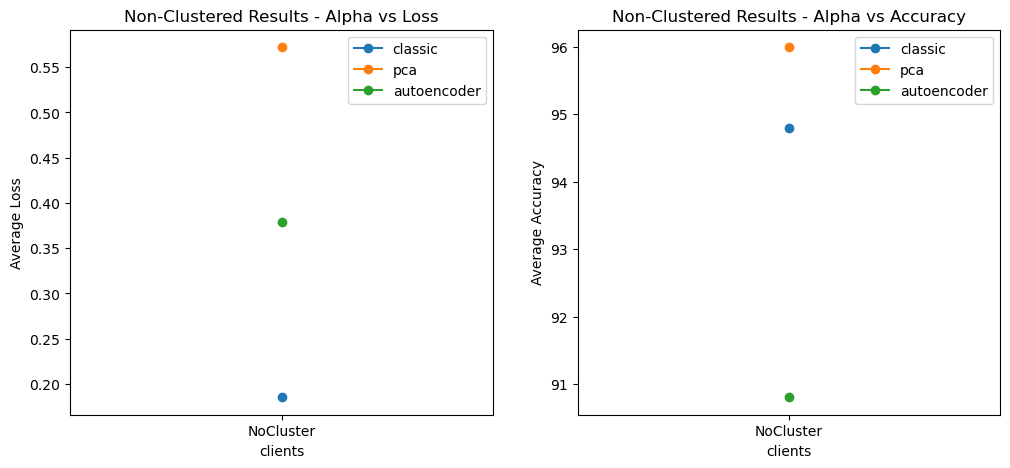


Clustered Results:
classic:
  Average Loss: {2: 0.07224598731994629, 4: 0.046959210395812995, 6: 0.042733738279342647, 8: 0.03977022566795349, 10: 0.03886949486732483}
  Average Accuracy: {2: 97.75750000000001, 4: 98.4875, 6: 98.6275, 8: 98.69, 10: 98.71}
pca:
  Average Loss: {2: 0.2665757312774658, 4: 0.18807879829406737, 6: 0.16758423652648927, 8: 0.16059208335876465, 10: 0.15428607788085938}
  Average Accuracy: {2: 98.04500000000002, 4: 98.58000000000001, 6: 98.71, 8: 98.77000000000001, 10: 98.74499999999999}
autoencoder:
  Average Loss: {2: 0.19661765193939207, 4: 0.14253459548950198, 6: 0.12923321981430053, 8: 0.1195388500213623, 10: 0.1168597354888916}
  Average Accuracy: {2: 96.095, 4: 97.29749999999999, 6: 97.56, 8: 97.68, 10: 97.80749999999999}


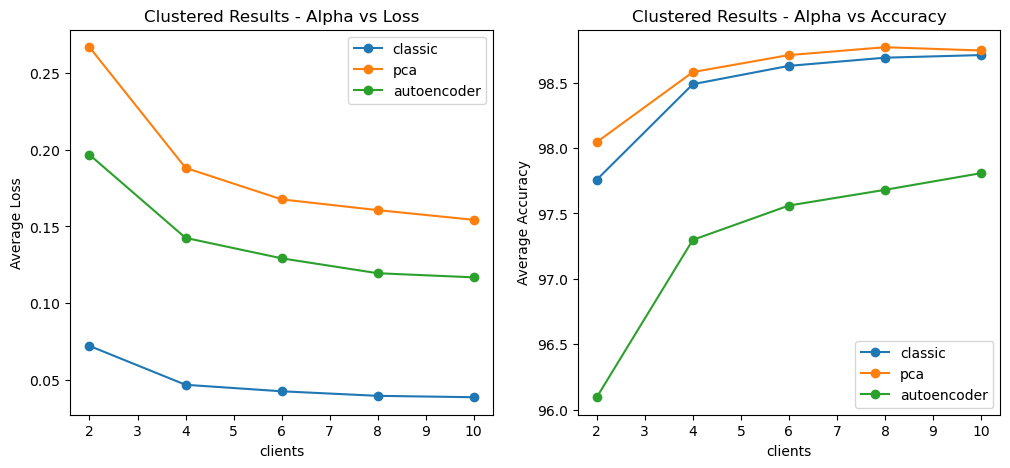

In [40]:
import numpy as np
import matplotlib.pyplot as plt

def compute_avg(metrics):
    avg_loss = {alpha: np.mean(data['losses']) for alpha, data in metrics.items()}
    avg_accuracy = {alpha: np.mean(data['accuracy']) for alpha, data in metrics.items()}
    return avg_loss, avg_accuracy

def print_results(results, title):
    print(f"\n{title}:")
    for method in results.keys():
        avg_loss, avg_accuracy = compute_avg(results[method])
        print(f"{method}:")
        print("  Average Loss:", avg_loss)
        print("  Average Accuracy:", avg_accuracy)

def plot_results(results, title, filename):
    plt.figure(figsize=(12, 5))
    
    # Loss Plot
    plt.subplot(1, 2, 1)
    for method in results.keys():
        avg_loss, _ = compute_avg(results[method])
        plt.plot(avg_loss.keys(), avg_loss.values(), marker='o', label=method)
    plt.xlabel('clients')
    plt.ylabel('Average Loss')
    plt.title(f'{title} - Alpha vs Loss')
    plt.legend()
    
    # Accuracy Plot
    plt.subplot(1, 2, 2)
    for method in results.keys():
        _, avg_accuracy = compute_avg(results[method])
        plt.plot(avg_accuracy.keys(), avg_accuracy.values(), marker='o', label=method)
    plt.xlabel('clients')
    plt.ylabel('Average Accuracy')
    plt.title(f'{title} - Alpha vs Accuracy')
    plt.legend()
    plt.show()


print_results(results, "Non-Clustered Results")
plot_results(results, "Non-Clustered Results", "non_clustered_results.png")
print_results(clusteredResults, "Clustered Results")
plot_results(clusteredResults, "Clustered Results", "clustered_results.png")